In [1]:
import librosa
import mir_eval
import glob
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os

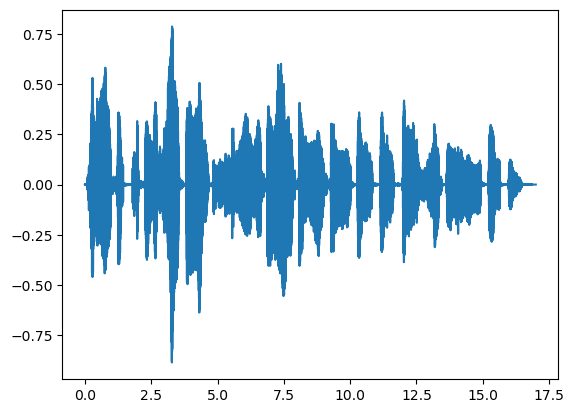

In [2]:
y, sr = librosa.load('crybaby.wav', sr = 44100)
t = np.arange(0, y.shape[0]/sr, 1/sr)
plt.plot(t,y)

1.(a)
Explain the audio content shown on the spectrogram. 

1. Harmonic Structure: The repeating vertical patterns represent the characteristic of baby crying. 

2. Variability in Intensity: The spectrogram shows significant variability in intensity over time. This variability corresponds to the volume of the crying changing over time—louder cries appear brighter and quieter moments appear darker.

3. Temporal Features:  The spacing between the bright vertical bands may provide information about the rhythm of the crying.





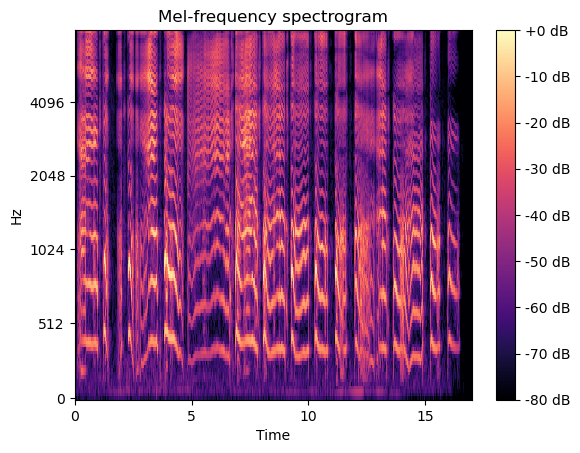

In [3]:

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
y_axis='mel', sr=sr,
fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
fig.savefig('melspec.png', dpi=300)

1.(b)
Please derive the IF of 𝑥2.

In [4]:
from sympy import symbols, sin, diff

# Define the variable and function for x2(t)
T = symbols('T', real=True, positive=True)
phi_1 = 2000* (T**2) 
phi_2 = 2000*T + 10*sin(2.5*T**2)

# Calculate the derivative of the phase function, which gives us the instantaneous frequency
f_1 = diff(phi_1, T) / (2 * symbols('pi'))
f_2 = diff(phi_2, T) / (2 * symbols('pi'))

# Display the result
f_1, f_2


(2000*T/pi, (50.0*T*cos(2.5*T**2) + 2000)/(2*pi))

1.(c)
 The pitch of x1.wav gets higher over time but suddenly decreases , whereas the pitch of x2.wav will have a more complex sound with a pitch that not only gets higher over time but also fluctuates, giving a warbling effect.  The reason why the pitch of x1.wav suddenly decreases may be 'Aliasing or Folding': If the signal frequency exceeds the Nyquist frequency at some point , aliasing could occur, where higher frequencies are misinterpreted as lower frequencies.


In [5]:
# Parameters
fs = 8000  # Sampling frequency of 8 kHz
duration = 10  # Duration in seconds
# Generate the time-domain signals for x1 and x2 within the range t ∈ [0, 10]
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
x1 = np.sin(2000 * t**2)
x2 = np.sin(2000 * t + 10 * np.sin(2.5 * t**2))

# Write to .wav files with a sampling frequency of 8 kHz
sf.write('x1.wav', x1, fs)
sf.write('x2.wav', x2, fs)


1.(d)
1. Left spectrogram: the IF curve (cyan line)  of x1 increases linearly over time, which is consistent with the mathematical description of x1(t). The brightest line in the spectrogram closely follows this IF curve before the 6th second.

2. Right spectrogram: the IF curve (cyan line)  of x2 contains fluctuations due to the  10*sin(2.5* t**2) in x2.

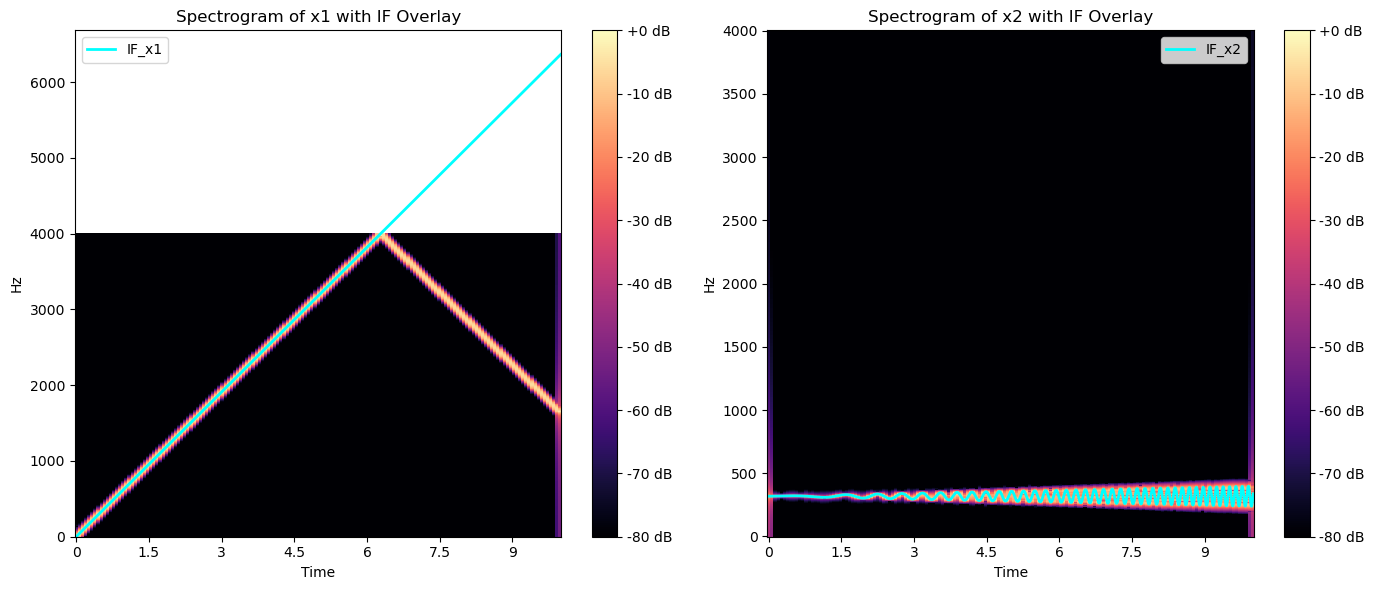

In [6]:

IF_x1 = 4000 * t / (2 * np.pi)
IF_x2 = (2000 + 50 * t * np.cos(2.5 * t**2)) / (2 * np.pi)

# STFT
n_fft = 2048
hop_length = 512
D_x1 = librosa.stft(x1, n_fft=n_fft, hop_length=hop_length)
D_x2 = librosa.stft(x2, n_fft=n_fft, hop_length=hop_length)

# Convert to dB
D_x1_db = librosa.amplitude_to_db(np.abs(D_x1), ref=np.max)
D_x2_db = librosa.amplitude_to_db(np.abs(D_x2), ref=np.max)

# Plot
plt.figure(figsize=(14, 6))

# x1
plt.subplot(1, 2, 1)
librosa.display.specshow(D_x1_db, sr=fs, x_axis='time', y_axis='linear', hop_length=hop_length)
plt.plot(t, IF_x1, color='cyan', linewidth=2, label='IF_x1')
plt.title('Spectrogram of x1 with IF Overlay')
plt.colorbar(format='%+2.0f dB')
plt.legend()

# x2
plt.subplot(1, 2, 2)
librosa.display.specshow(D_x2_db, sr=fs, x_axis='time', y_axis='linear', hop_length=hop_length)
plt.plot(t, IF_x2, color='cyan', linewidth=2, label='IF_x2')
plt.title('Spectrogram of x2 with IF Overlay')
plt.colorbar(format='%+2.0f dB')
plt.legend()

plt.tight_layout()
plt.show()


2.(a)
The Krumhansl-Schmuckler key-finding algorithm for global key detection.

In [7]:

import pandas as pd
from scipy import stats


# Function to create the Krumhansl-Schmuckler key profiles
def createKSTemplate():
    Majorks = np.zeros(shape=(12, 12))
    minorks = np.zeros(shape=(12, 12))
    Majortmp = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minortmp = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    for i in range(12):
        Majorks[i] = np.roll(Majortmp, i)
        minorks[i] = np.roll(minortmp, i)
    return Majorks, minorks

# Function to estimate the key from a chroma vector
def estimateKey(chroma_vector):
    MajorKS, minorKS = createKSTemplate()
    RMajor = [stats.pearsonr(chroma_vector, ks)[0] for ks in MajorKS]
    Rminor = [stats.pearsonr(chroma_vector, ks)[0] for ks in minorKS]

    if max(RMajor) > max(Rminor):
        key_index = RMajor.index(max(RMajor))
    else:
        key_index = Rminor.index(max(Rminor)) + 12  # Adding 12 for minor keys
    
    return key_index

def key24_to_keyform(key24):
    key24table = [
        'C major', 'C# major', 'D major', 'D# major', 'E major', 'F major',
        'F# major', 'G major', 'G# major', 'A major', 'A# major', 'B major',
        'C minor', 'C# minor', 'D minor', 'D# minor', 'E minor', 'F minor',
        'F# minor', 'G minor', 'G# minor', 'A minor', 'A# minor', 'B minor'
    ]
    return key24table[key24]


def keyform_to_key24(keyform):
    keyform_map = {
        'Db:maj': 'C#:maj',
        'Eb:maj': 'D#:maj',
        'Gb:maj': 'F#:maj',
        'Ab:maj': 'G#:maj',
        'Bb:maj': 'A#:maj',
        'Db:min': 'C#:min',
        'Eb:min': 'D#:min',
        'Gb:min': 'F#:min',
        'Ab:min': 'G#:min',
        'Bb:min': 'A#:min'
    }
    keyform = keyform_map.get(keyform, keyform)

    key24table = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'F:maj', 'F#:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj', 'B:maj',
                  'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min', 'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min']
    return key24table.index(keyform)

def findkey(feature_setting, y, sr):
    if feature_setting == 1:
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512, n_fft= 4096)
    elif feature_setting == 2:
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    elif feature_setting == 3:
        chroma = librosa.feature.chroma_cens(y=y, sr=sr,)
    chroma_avg = np.average(chroma, axis=1)
    est_key_index = estimateKey(chroma_avg)

    return est_key_index

def ACC(ref_est):
    correct_cnt = 0
    score = 0
    for (ref_key_index, est_key_index) in ref_est:
        ref_key = key24_to_keyform(ref_key_index)
        est_key = key24_to_keyform(est_key_index)
        if ref_key_index == est_key_index:
            correct_cnt += 1
        tmp = mir_eval.key.evaluate(ref_key, est_key)
        score += tmp['Weighted Score']

    raw_acc = correct_cnt / len(ref_est)
    weighted_acc = score / len(ref_est)
    return raw_acc, weighted_acc



I use early fusion fusion approaches to implement. My experiment results suggest that CQT-based chroma features might be the most suitable for global key detection in this particular dataset, since it has the highest weighted accuracy. However, none of the methods achieved high raw accuracy.

In [8]:
df = pd.read_csv('ann_audio_globalkey.csv', delimiter=';')

wav_files = glob.glob(os.path.join('audio_wav', '*SC06.wav'))
audio_data = []
for wav_file in wav_files:
    y, sr = librosa.load(wav_file, sr=44100)
    audio_data.append((y, sr))
    
gt_keyform = []
for i in range(len(df)):
    if df.loc[i, 'PerformanceID'] == 'SC06' :
        gt_keyform.append(df.loc[i, 'key'])
        
# print(gt_keyform)

ref_est = []


    
for i in range(1, 4):
    ref_est = []
    if i == 1:
        feature = 'STFT'
    elif i == 2:
        feature = 'CQT'
    else:
        feature = 'CENS'
    gt_key = [keyform_to_key24(key) for key in gt_keyform]
    

    for j in range(len(gt_key)):
        y, sr = audio_data[j]
        ref_est.append((gt_key[j], findkey(i, y, sr)))
    print(ref_est)
    ra, wa = ACC(ref_est)
    
    print(f"Feature Setting {feature}: RA = {ra}, WA = {wa}")


    


[(12, 22), (19, 9), (15, 7), (22, 12), (2, 8), (14, 21), (14, 17), (17, 3), (21, 5), (22, 22), (7, 21), (21, 0), (1, 15), (22, 19), (22, 22), (1, 7), (0, 2), (12, 9), (7, 14), (17, 12), (3, 0), (17, 8), (7, 23), (19, 0)]
Feature Setting STFT: RA = 0.08333333333333333, WA = 0.15
[(12, 22), (19, 9), (15, 2), (22, 12), (2, 8), (14, 21), (14, 17), (17, 3), (21, 5), (22, 22), (7, 21), (21, 5), (1, 22), (22, 19), (22, 22), (1, 7), (0, 2), (12, 9), (7, 14), (17, 12), (3, 0), (17, 8), (7, 7), (19, 0)]
Feature Setting CQT: RA = 0.125, WA = 0.19166666666666665
[(12, 22), (19, 9), (15, 2), (22, 12), (2, 8), (14, 21), (14, 17), (17, 3), (21, 5), (22, 22), (7, 21), (21, 5), (1, 6), (22, 19), (22, 22), (1, 7), (0, 2), (12, 9), (7, 14), (17, 12), (3, 0), (17, 8), (7, 23), (19, 0)]
Feature Setting CENS: RA = 0.08333333333333333, WA = 0.13749999999999998


2.(b) Local Key Detection 


In [9]:
# create estimated key list every 0.1 second
y, sr = librosa.load('Schubert_D911-01_SC06.wav', sr=44100)
df = pd.read_csv('Schubert_D911-01_SC06.csv', delimiter=';')
hop_length = int(sr * 0.1)  # hop length for 0.1 second windows
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft= 10000)
key_estimations = [estimateKey(chroma[:, i]) for i in range(chroma.shape[1])]
print(key_estimations)

[20, 23, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 12, 3, 3, 3, 12, 12, 12, 3, 3, 12, 12, 12, 3, 3, 3, 3, 3, 12, 3, 3, 12, 12, 12, 7, 12, 12, 12, 12, 12, 3, 3, 3, 3, 3, 3, 15, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 19, 19, 19, 19, 12, 2, 23, 23, 23, 17, 17, 12, 12, 12, 0, 0, 0, 12, 12, 12, 12, 12, 12, 7, 7, 7, 7, 7, 7, 17, 8, 17, 17, 0, 0, 0, 19, 3, 3, 3, 3, 3, 19, 19, 19, 19, 19, 17, 17, 17, 3, 3, 3, 3, 12, 12, 12, 12, 0, 12, 12, 12, 12, 12, 12, 12, 0, 0, 7, 7, 7, 7, 7, 7, 23, 7, 7, 7, 7, 7, 12, 12, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 0, 3, 3, 3, 3, 3, 3, 12, 12, 12, 14, 2, 12, 12, 12, 12, 12, 12, 3, 15, 19, 19, 19, 3, 3, 3, 3, 3, 12, 17, 17, 8, 8, 12, 17, 8, 8, 8, 12, 12, 17, 17, 1, 12, 12, 17, 0, 0, 12, 12, 12, 3, 3, 3, 3, 15, 15, 3, 12, 12, 12, 12, 12, 3, 3, 3, 3, 3, 3, 7, 23, 11, 15, 23, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 3, 3, 3, 3, 9, 9, 2, 2, 2, 3, 12, 12, 12, 11, 12, 12, 12, 12, 17, 7, 3, 3, 3, 3, 12, 12, 17, 12, 8, 12, 

In [10]:
# Create a validation DataFrame 
key_intervals_df = pd.DataFrame(columns=['time', 'key'])

current_key_index = 0
for time in np.arange(df['start'][0], 50, 0.1):
    while current_key_index < len(df) - 1 and time >= df['end'].iloc[current_key_index]:
        current_key_index += 1
    if time >= df['start'].iloc[current_key_index]:
        current_key = df['key'].iloc[current_key_index]
        key_intervals_df.loc[len(key_intervals_df)] = [time, current_key]

print(key_intervals_df)


      time     key
0     0.24   C:min
1     0.34   C:min
2     0.44   C:min
3     0.54   C:min
4     0.64   C:min
..     ...     ...
493  49.54  G#:maj
494  49.64  G#:maj
495  49.74  G#:maj
496  49.84  G#:maj
497  49.94  G#:maj

[498 rows x 2 columns]


In [11]:
reference_key_indices = []

for _, row in key_intervals_df.iterrows():
    key_index = keyform_to_key24(row['key'])
    reference_key_indices.append(key_index)

aligned_estimated_keys = key_estimations[3:len(reference_key_indices) + 3]
ref_est_pairs = list(zip(reference_key_indices, aligned_estimated_keys))
print(len(ref_est_pairs))

raw_accuracy, weighted_accuracy = ACC(ref_est_pairs)
print(f"Raw Accuracy: {raw_accuracy}")
print(f"Weighted Accuracy: {weighted_accuracy}")

498
Raw Accuracy: 0.41365461847389556
Weighted Accuracy: 0.5114457831325301


In [12]:

# # Step 2: Extract the intervals and labels from the DataFrame
# ground_truth_intervals = df[['start', 'end']].values
# ground_truth_labels = df['key'].tolist()

# def compute_chroma(y, sr):
#     return librosa.feature.chroma_stft(y=y, sr=sr)

# # Function to smooth the signal using a moving average
# def smooth(x, window_len=9):
#     window = np.ones(window_len) / window_len
#     return np.convolve(x, window, mode='same')

# # Estimate keys for each interval
# chroma = compute_chroma(y, sr)

# # Calculate the difference between successive chroma feature frames
# chroma_diff = np.sum(np.abs(np.diff(chroma, axis=1)), axis=0)

# # Smooth the chroma difference signal
# chroma_diff_smoothed = smooth(chroma_diff)

# # Apply a threshold to determine key change points
# threshold = np.median(chroma_diff_smoothed) * 1.5
# key_change_indices = np.where(chroma_diff_smoothed > threshold)[0]

# # Convert frame indices to time
# key_change_times = librosa.frames_to_time(key_change_indices, sr=sr)




In [13]:
hop_length = int(sr * 1)  # hop length for 1 second windows
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft= 10000)
key_estimations = [estimateKey(chroma[:, i]) for i in range(chroma.shape[1])]
print(key_estimations)
print(len(key_estimations))

[20, 3, 3, 12, 12, 12, 12, 17, 12, 17, 3, 17, 12, 7, 7, 12, 3, 12, 3, 12, 12, 3, 3, 23, 12, 3, 12, 3, 8, 12, 6, 3, 12, 12, 20, 15, 12, 15, 10, 19, 15, 8, 3, 12, 8, 17, 20, 16, 12, 8, 3, 8, 8, 14, 3, 12, 7, 12, 14, 3, 0, 7, 3, 3, 19, 12, 12, 3, 17, 12, 7, 7, 19, 15, 15, 12, 12, 3, 3, 12, 19, 12, 12, 17, 19, 15, 12, 7, 0, 12, 12, 12, 15, 1, 17, 8, 3, 3, 3, 3, 12, 3, 17, 0, 12, 12, 12, 12, 20, 3, 3, 12, 11, 22, 3, 19, 3, 3, 8, 8, 8, 3, 3, 8, 3, 12, 8, 12, 12, 17, 19, 12, 8, 20, 7, 8, 15, 3, 7, 12, 12, 18, 8, 7, 8, 3, 3, 23, 3, 3, 3, 3, 12, 19, 12, 12, 12, 3, 3, 12, 23, 12, 12, 15, 12, 17, 12, 17, 19, 19, 12, 3, 12, 12, 8, 12, 12, 12, 7, 12, 8, 10, 12, 15, 10, 15, 3, 14, 19, 3, 8, 12, 8, 3, 13, 8, 11, 1, 8, 8, 17, 17, 7, 12, 14, 15, 1, 12, 0, 19, 19, 7, 12, 12, 18, 0, 7, 19, 19, 19, 0, 8, 3, 3, 12, 12, 7, 20, 12, 17, 12, 5, 0, 12, 7, 0, 0, 16, 13, 0, 9, 12, 3, 0, 17, 0, 0, 16, 0, 0, 21, 21, 6, 0, 11, 0, 5, 5, 21, 23, 0, 12, 22, 6, 8, 19, 6, 0, 4, 7, 16, 11, 7, 17, 7, 15, 0, 2, 16, 12, 7, 0

In [14]:


one_sec_interval = pd.DataFrame(columns=['start', 'end', 'key'])

for i in range(0, len(key_estimations)-1):
    one_sec_interval.loc[i, 'start'] = i 
    one_sec_interval.loc[i, 'end'] = i +1
   

for j in range(0, len(key_estimations) - 1 ):
    keyform = key24_to_keyform(key_estimations[j])
    one_sec_interval.loc[j, 'key'] = keyform


print(one_sec_interval)

    start  end       key
0       0    1  G# minor
1       1    2  D# major
2       2    3  D# major
3       3    4   C minor
4       4    5   C minor
..    ...  ...       ...
320   320  321  D# major
321   321  322   C minor
322   322  323   C minor
323   323  324   C minor
324   324  325   C minor

[325 rows x 3 columns]


In [15]:
# find the interval when key changes

changes_df = pd.DataFrame(columns=['start', 'end', 'key'])

# Iterate over the DataFrame to detect key changes
prev_key = one_sec_interval.loc[0, 'key']
prev_start = one_sec_interval.loc[0, 'start']
for index, row in one_sec_interval.iterrows():
    if row['key'] != prev_key:

        new_row = pd.DataFrame({'start': [prev_start], 'end': row['start'], 'key': [prev_key]})
        changes_df = pd.concat([changes_df, new_row], ignore_index=True)
        prev_key = row['key']
        prev_start = row['start']

# Add the last interval
new_row = pd.DataFrame({'start': [prev_start], 'end': [one_sec_interval.iloc[-1]['start']], 'key': [prev_key]})
changes_df = pd.concat([changes_df, new_row], ignore_index=True)

changes_df


,start,end,key
0,0,1,G# minor
1,1,3,D# major
2,3,7,C minor
3,7,8,F minor
4,8,9,C minor
...,...,...,...
253,316,317,D# major
254,317,318,B minor
255,318,319,D minor
256,319,321,D# major


In [16]:
ground_truth_intervals = df[['start', 'end']].values
predicted_intervals =  changes_df[['start', 'end']].values
# print(predicted_intervals)
# Step 3: Calculate the over-segmentation and under-segmentation using mir_eval
over_segmentation = mir_eval.chord.overseg(ground_truth_intervals, predicted_intervals)
under_segmentation = mir_eval.chord.underseg(ground_truth_intervals, predicted_intervals)
average_segmentation = mir_eval.chord.seg(ground_truth_intervals, predicted_intervals)
# Print or return the computed metrics
print('Over-segmentation:', over_segmentation)
print('Under-segmentation:', under_segmentation)
print('Average Segmentation Measure:', average_segmentation)

Over-segmentation: 0.11371896753526778
Under-segmentation: 0.9838271604938272
Average Segmentation Measure: 0.11371896753526778
